In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8,5]
%matplotlib inline
%config InlineBackend.figure_format='retina'
from tqdm import tqdm

from scipy import integrate
from scipy.stats import norm, uniform, loguniform
from astroML.plotting import hist
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

import warnings; warnings.simplefilter('ignore')
import corner
import dynesty
from dynesty import plotting as dyplot
import time

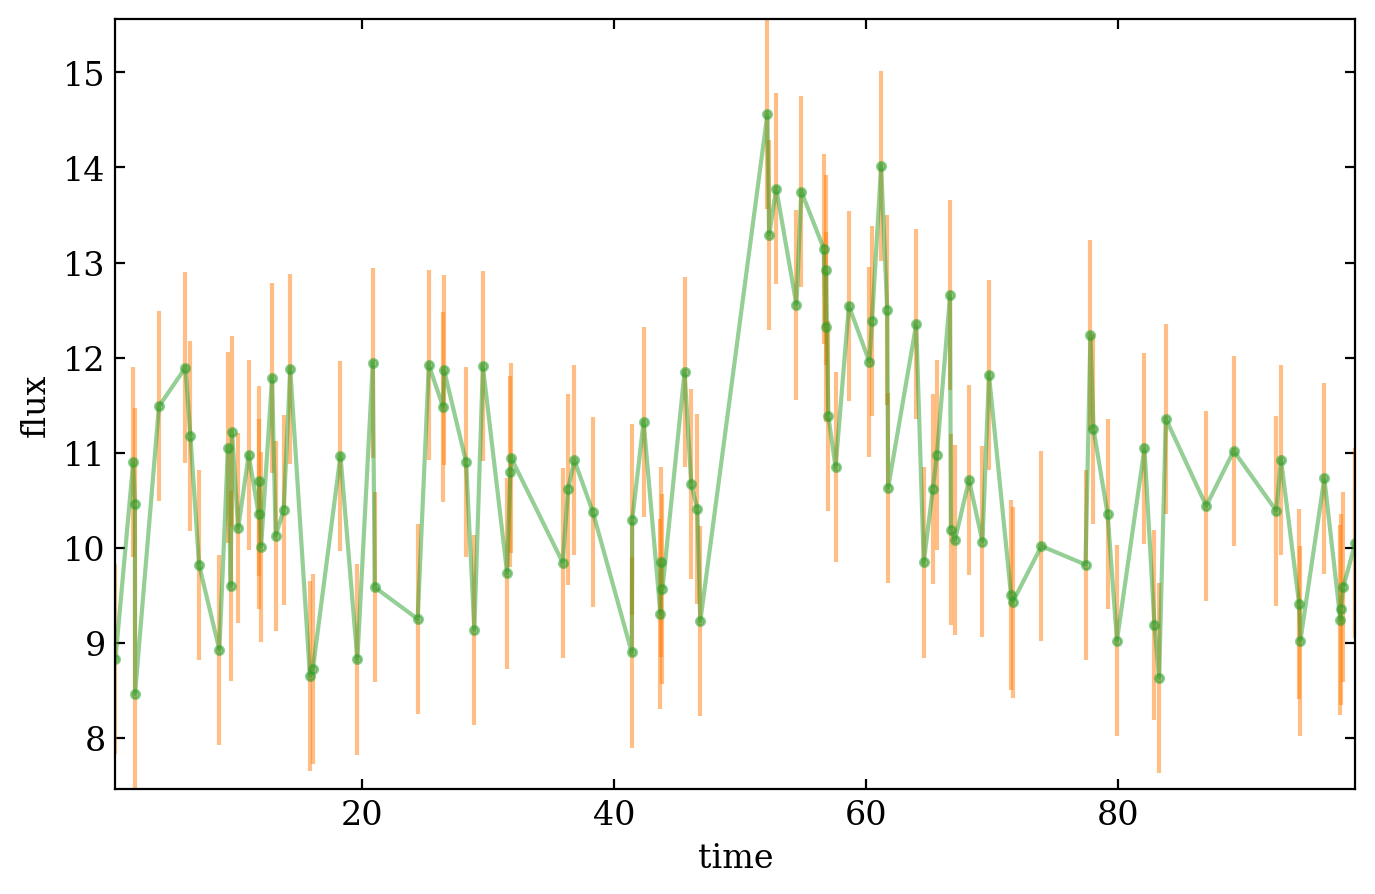

In [13]:
np.random.seed(42)
t = np.load('transient.npy')[:,0]
flux = np.load('transient.npy')[:,1]
err = np.load('transient.npy')[:,2]
tgrid=np.linspace(min(t),max(t),100)
plt.errorbar(t, flux, err, ecolor='C1', capthick=0, marker='.', c='C2',alpha=0.5)
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

In [14]:
def sharp_burst1(t, param):
    y=np.zeros(len(t))
    b = param[0]
    A = param[1]
    t0 = param[2]
    alpha = param[3]
    y[t<t0]=b
    y[t>=t0]= A*np.exp(-alpha*(t[t>=t0]-t0)) + b
    return y  

def sharp_burst2(t, param):
    y=np.zeros(len(t))
    b = param[0]
    A = param[1]
    t0 = param[2]
    sigmaW = param[3]
    y = A*np.exp(-(t-t0)**2 / (2*sigmaW**2)) + b
    return y  

def logLikelihood1(x, t, flux, err):
    logL=np.sum(np.log((1/((2*np.pi)**(1/2)*err))))+ np.sum(-((flux - sharp_burst1(t, x))**2)/(2*err**2))
    if not np.isfinite(logL):
        return -np.inf
    else:
        return logL

def logLikelihood2(x, t, flux, err):
    logL=np.sum(np.log((1/((2*np.pi)**(1/2)*err))))+ np.sum(-((flux - sharp_burst2(t, x))**2)/(2*err**2))
    if not np.isfinite(logL):
        return -np.inf
    else:
        return logL
    
def Prior_transform1(q):
    u_b=uniform(0,50)
    u_A=uniform(0,50)
    u_t0=uniform(0,100)
    u_alpha=loguniform(np.exp(-5),np.exp(5))
    b=u_b.ppf(q[0])
    A=u_A.ppf(q[1])
    t0=u_t0.ppf(q[2])
    alpha=u_alpha.ppf(q[3])
    return np.array([b, A, t0, alpha])

def Prior_transform2(q):
    u_b=uniform(0,50)
    u_A=uniform(0,30)
    u_t0=uniform(0,100)
    u_sigmaW=loguniform(np.exp(-4),np.exp(4))
    b=u_b.ppf(q[0])
    A=u_A.ppf(q[1])
    t0=u_t0.ppf(q[2])
    sigmaW=u_sigmaW.ppf(q[3])
    return np.array([b, A, t0, sigmaW])

#   u_logsigmaW=uniform(-4,8)
#    sigmaW=np.exp(u_logsigmaW.ppf(q[3]))

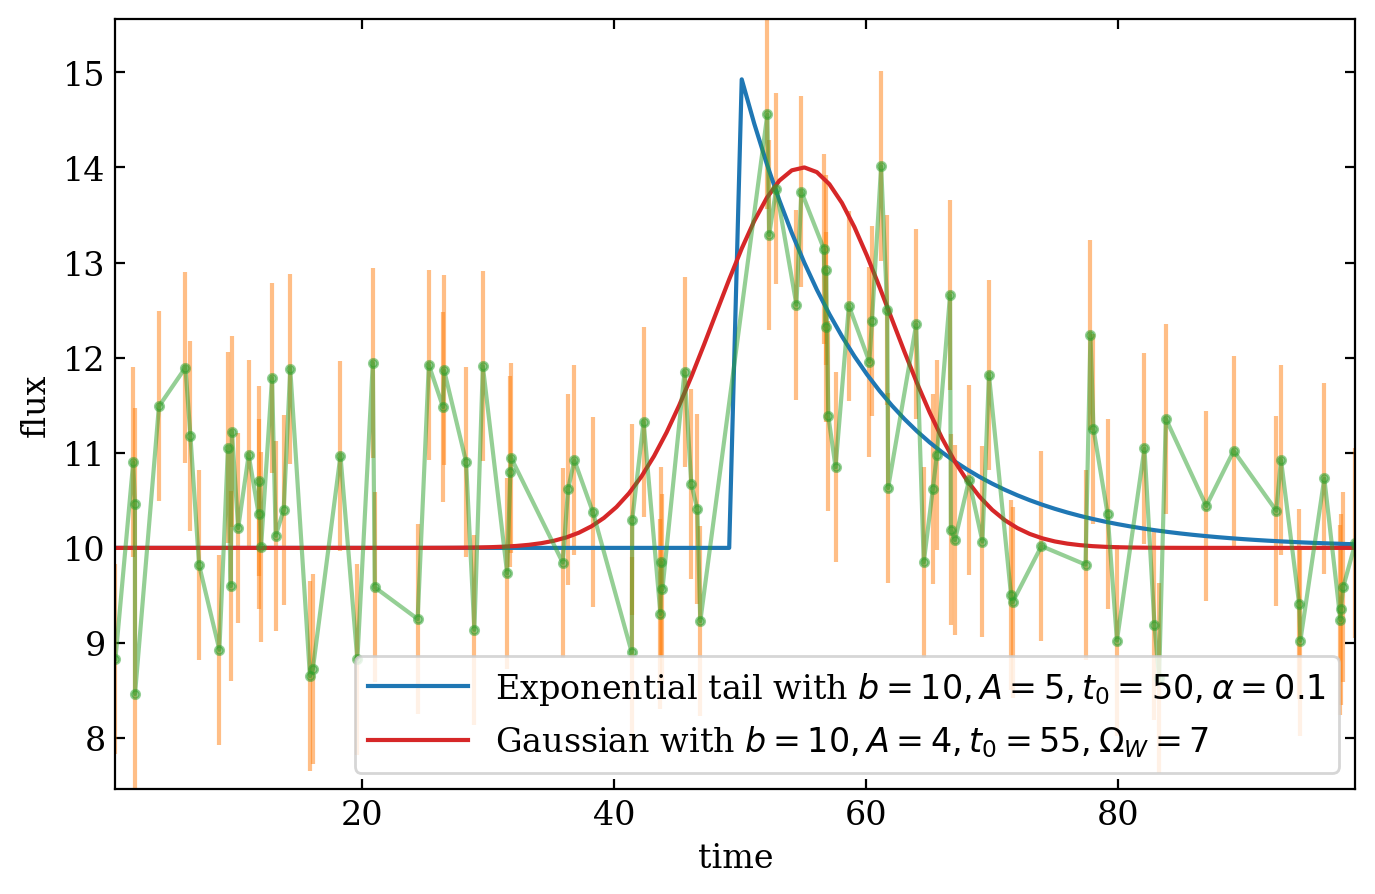

In [15]:
plt.errorbar(t, flux, err, ecolor='C1', capthick=0, marker='.', c='C2',alpha=0.5)
naive_param1 = [10, 5, 50, 0.1] #found by looking by eye at the max value of the LogLikelihood
naive_param2 = [10, 4, 55, 7] #found by looking by eye at the max value of the LogLikelihood

plt.plot(tgrid, sharp_burst1(tgrid, naive_param1), c='C0', label=r'Exponential tail with $b=10, A=5, t_0=50, \alpha=0.1$')
plt.plot(tgrid, sharp_burst2(tgrid, naive_param2), c='C3', label=r'Gaussian with $b=10, A=4, t_0=55, \Omega_W=7$')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend(loc='lower right')
plt.show()

### Sharp burst

In [16]:
ndim=4
sampler1 = dynesty.NestedSampler(logLikelihood1, Prior_transform1, ndim, logl_args=[t,flux,err])
sampler1.run_nested()
sresults1 = sampler1.results

7643it [02:58, 42.85it/s, +500 | bound: 120 | nc: 1 | ncall: 115695 | eff(%):  7.069 | loglstar:   -inf < -140.667 <    inf | logz: -155.169 +/-  0.167 | dlogz:  0.001 >  0.509]


Results: 

Bayesian evidence :  4.083564613362176e-68
b:   10.295   + 0.198   - 0.202
A:   5.397   + 3.583   - 1.775
t0:   49.126   + 2.648   - 2.061
alpha:   0.123   + 0.056   - 0.037


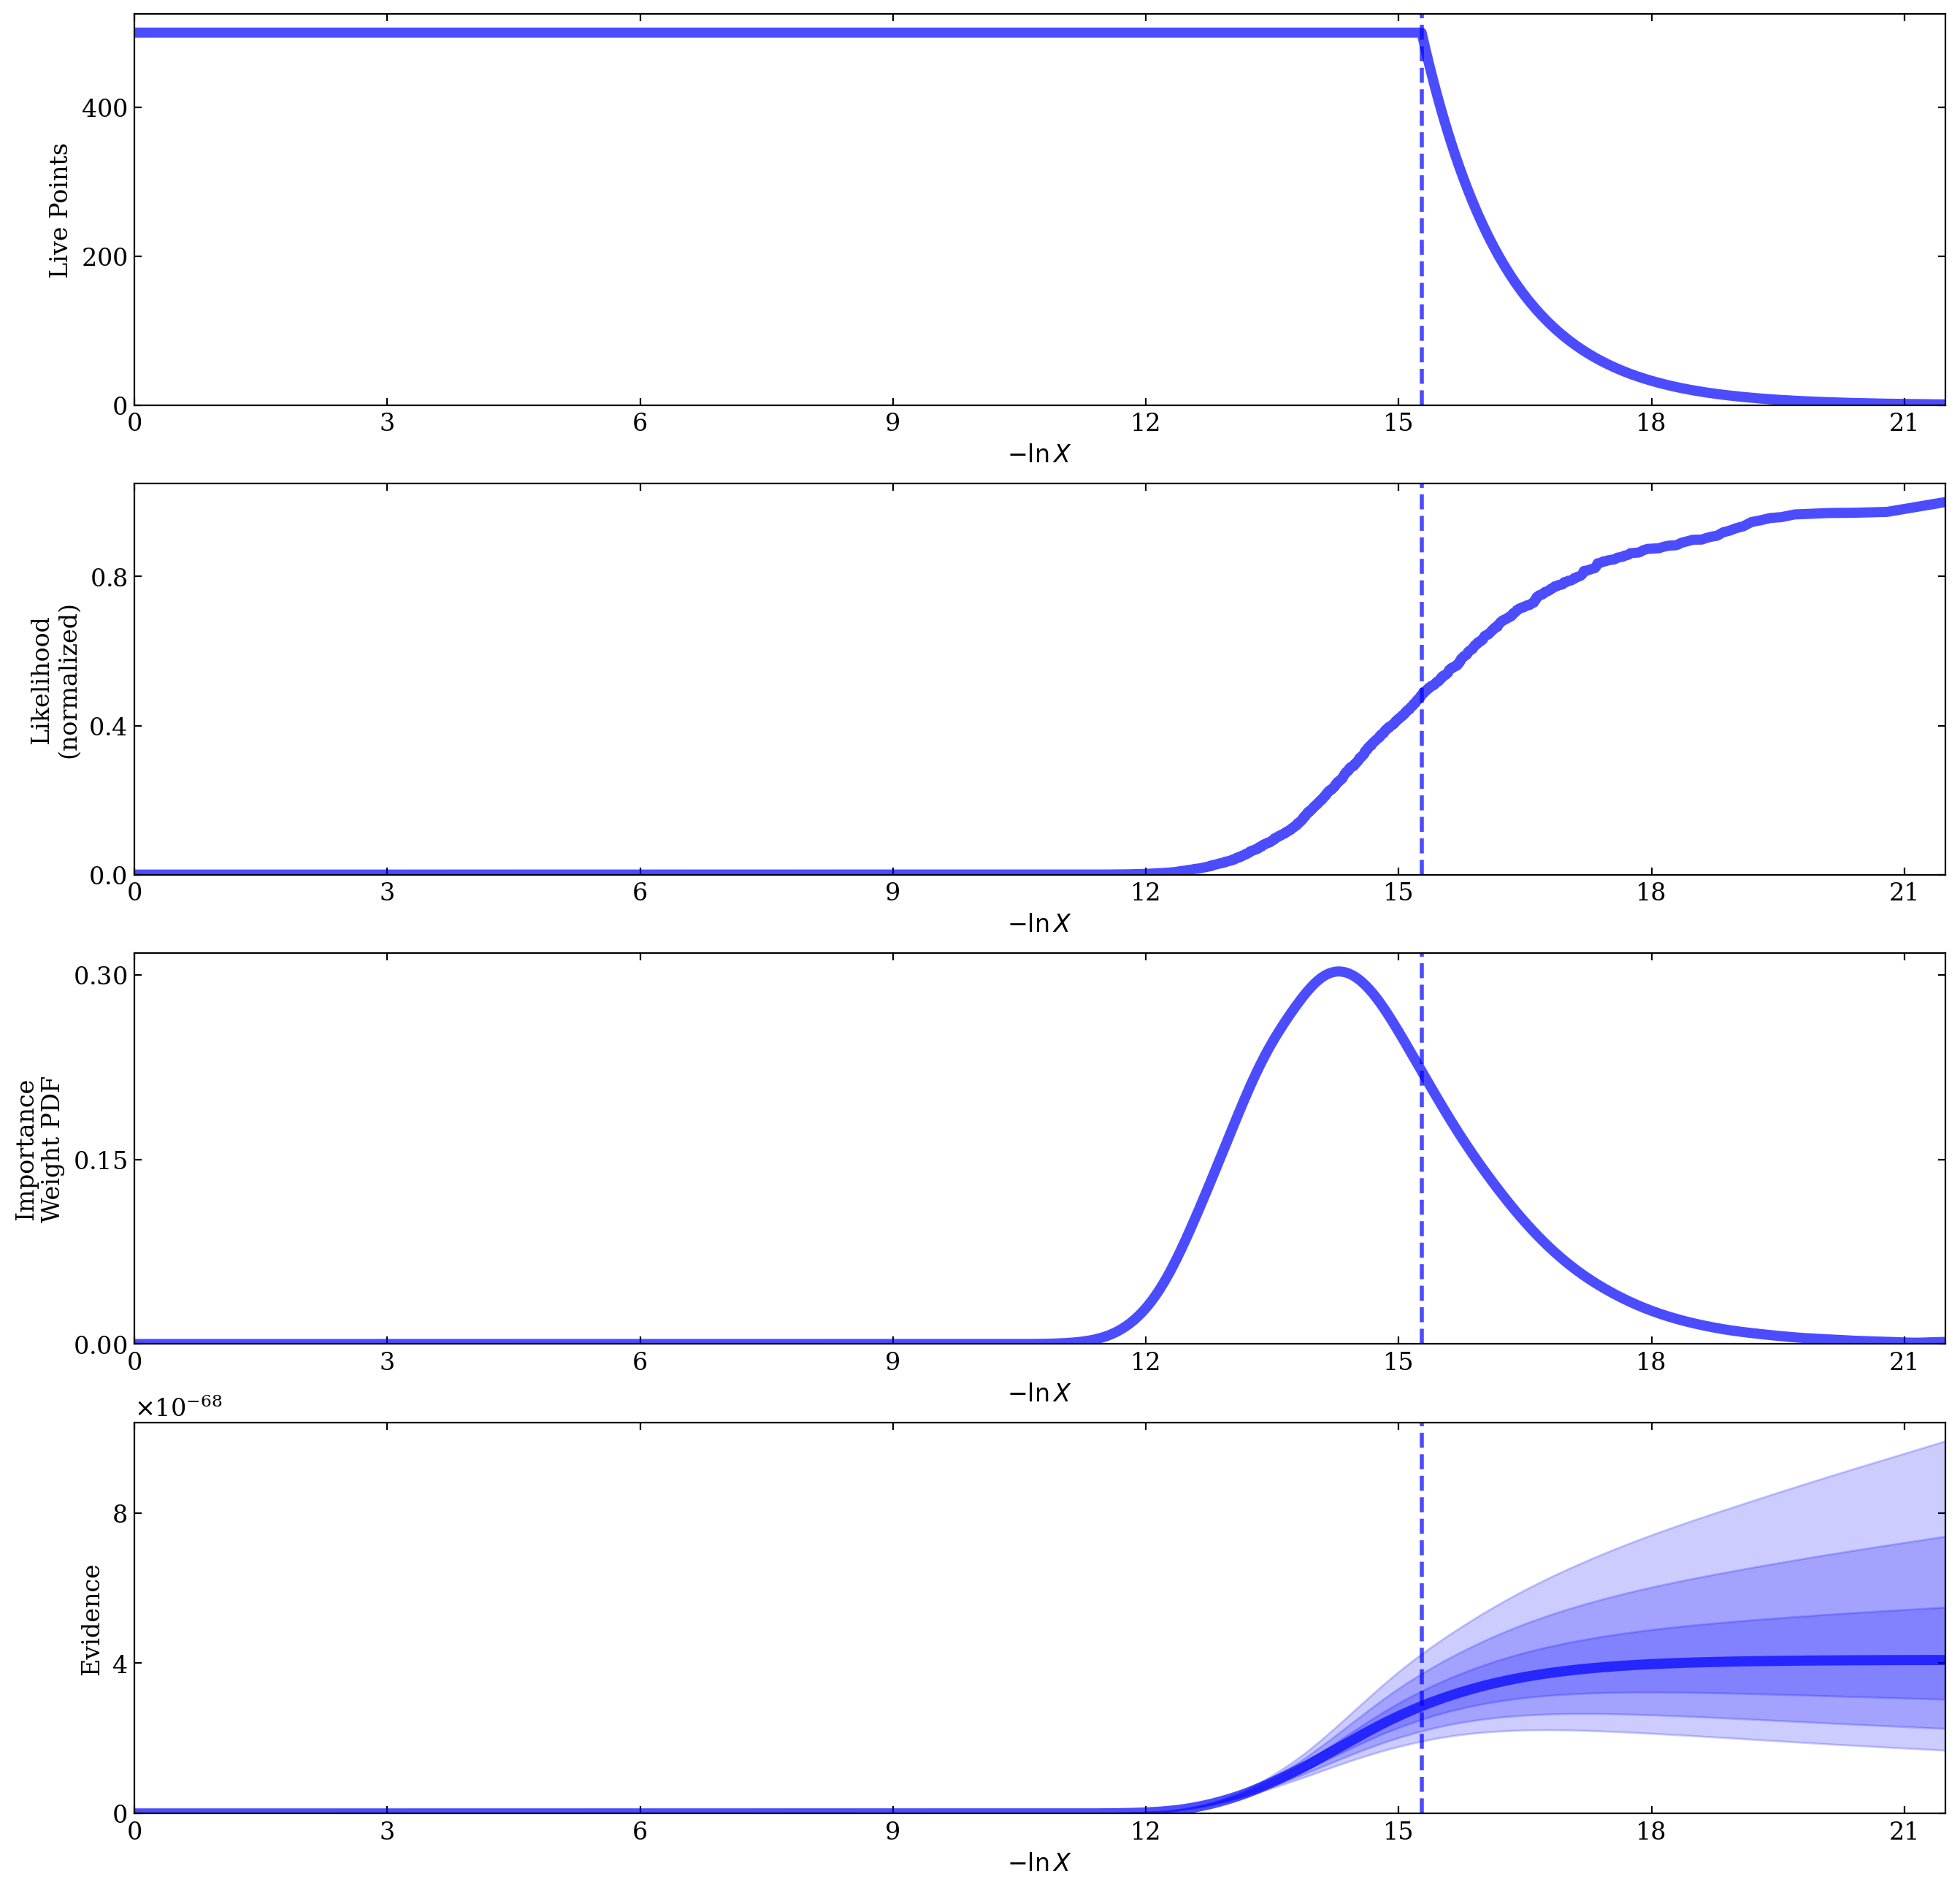

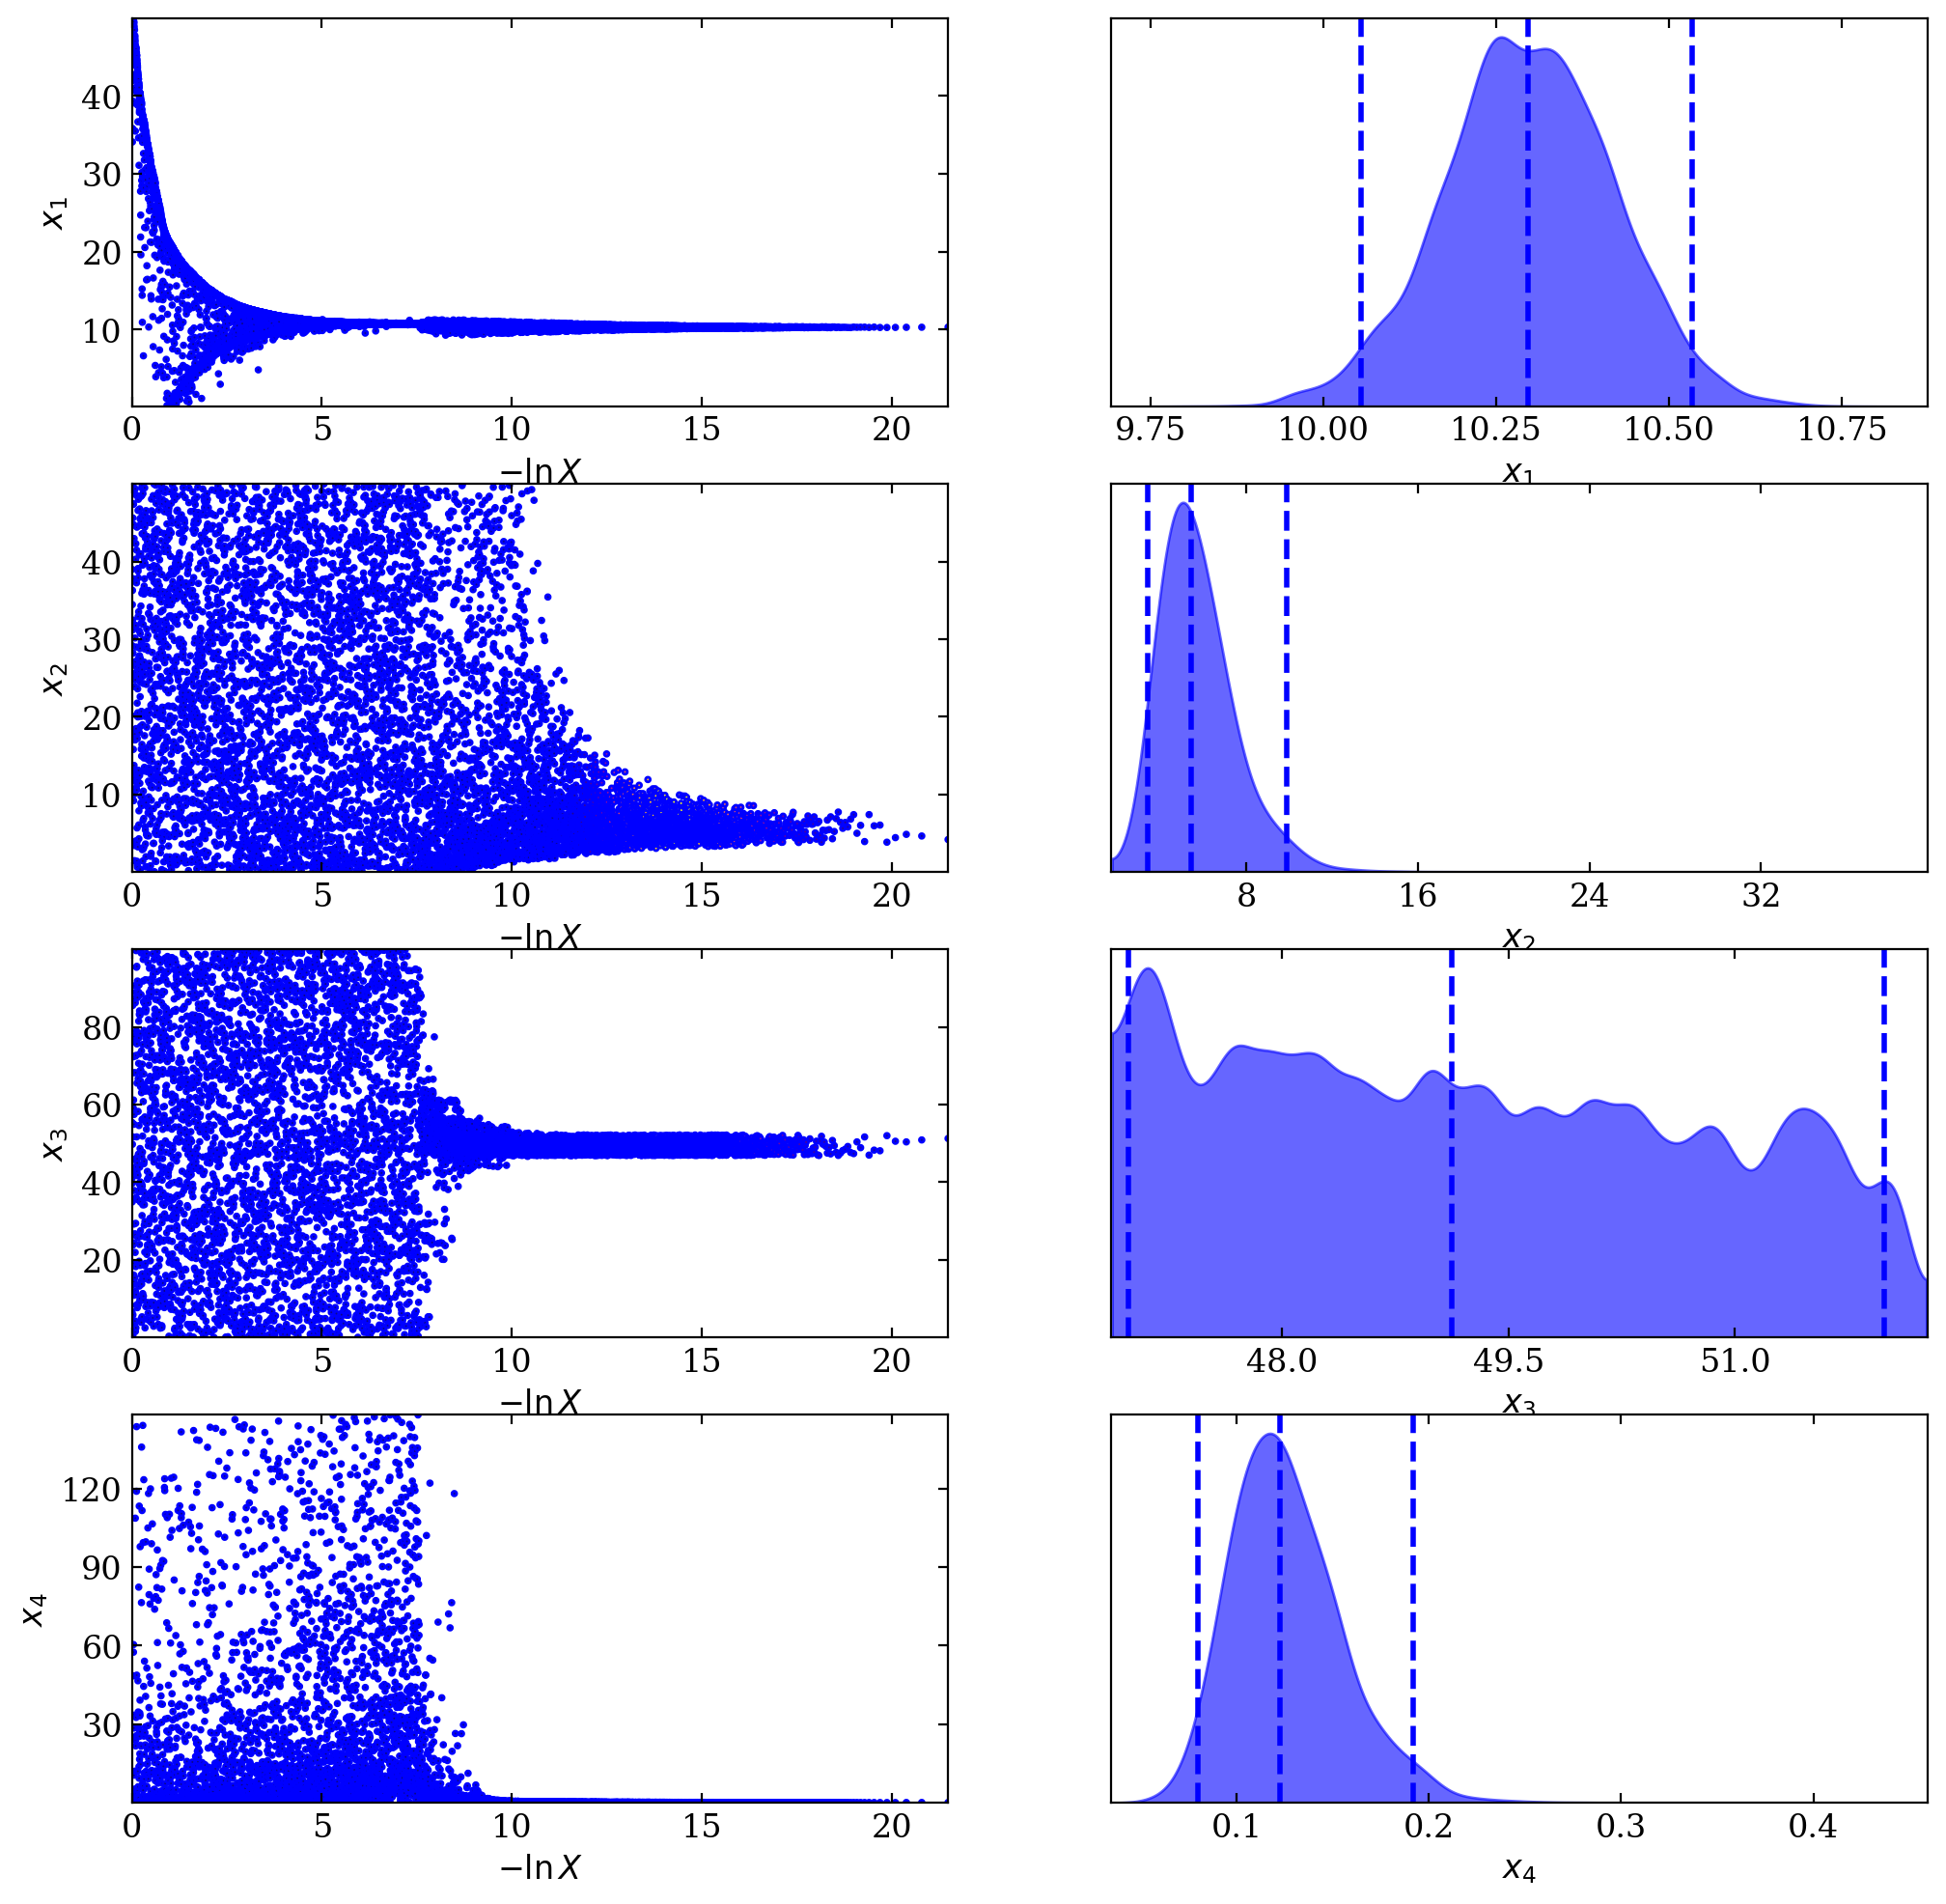

In [17]:
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
rfig, raxes = dyplot.runplot(sresults1)
tfig, taxes = dyplot.traceplot(sresults1)

# Extract sampling results.
print('Results: \n')
samples1 = sresults1.samples
weights1 = np.exp(sresults1.logwt - sresults1.logz[-1])

evidence1 = sresults1.logz[-1]
print("Bayesian evidence : ", np.exp(evidence1))

best_param1 = np.array([dyfunc.quantile(samps, 0.5, weights=weights1)
             for samps in samples1.T])
quantiles1 = np.array([dyfunc.quantile(samps, [0.05, 0.95], weights=weights1)
             for samps in samples1.T])

for i, l in zip(range(ndim),['b','A','t0','alpha']):
    X=best_param1[i].item()
    p5, p95 = quantiles1[i]
    print(l+':  ', round(X,3), '  +', round(p95.item()-X,3), '  -', round(X-p5.item(),3))
    
best_model1 = sharp_burst1(tgrid, best_param1)

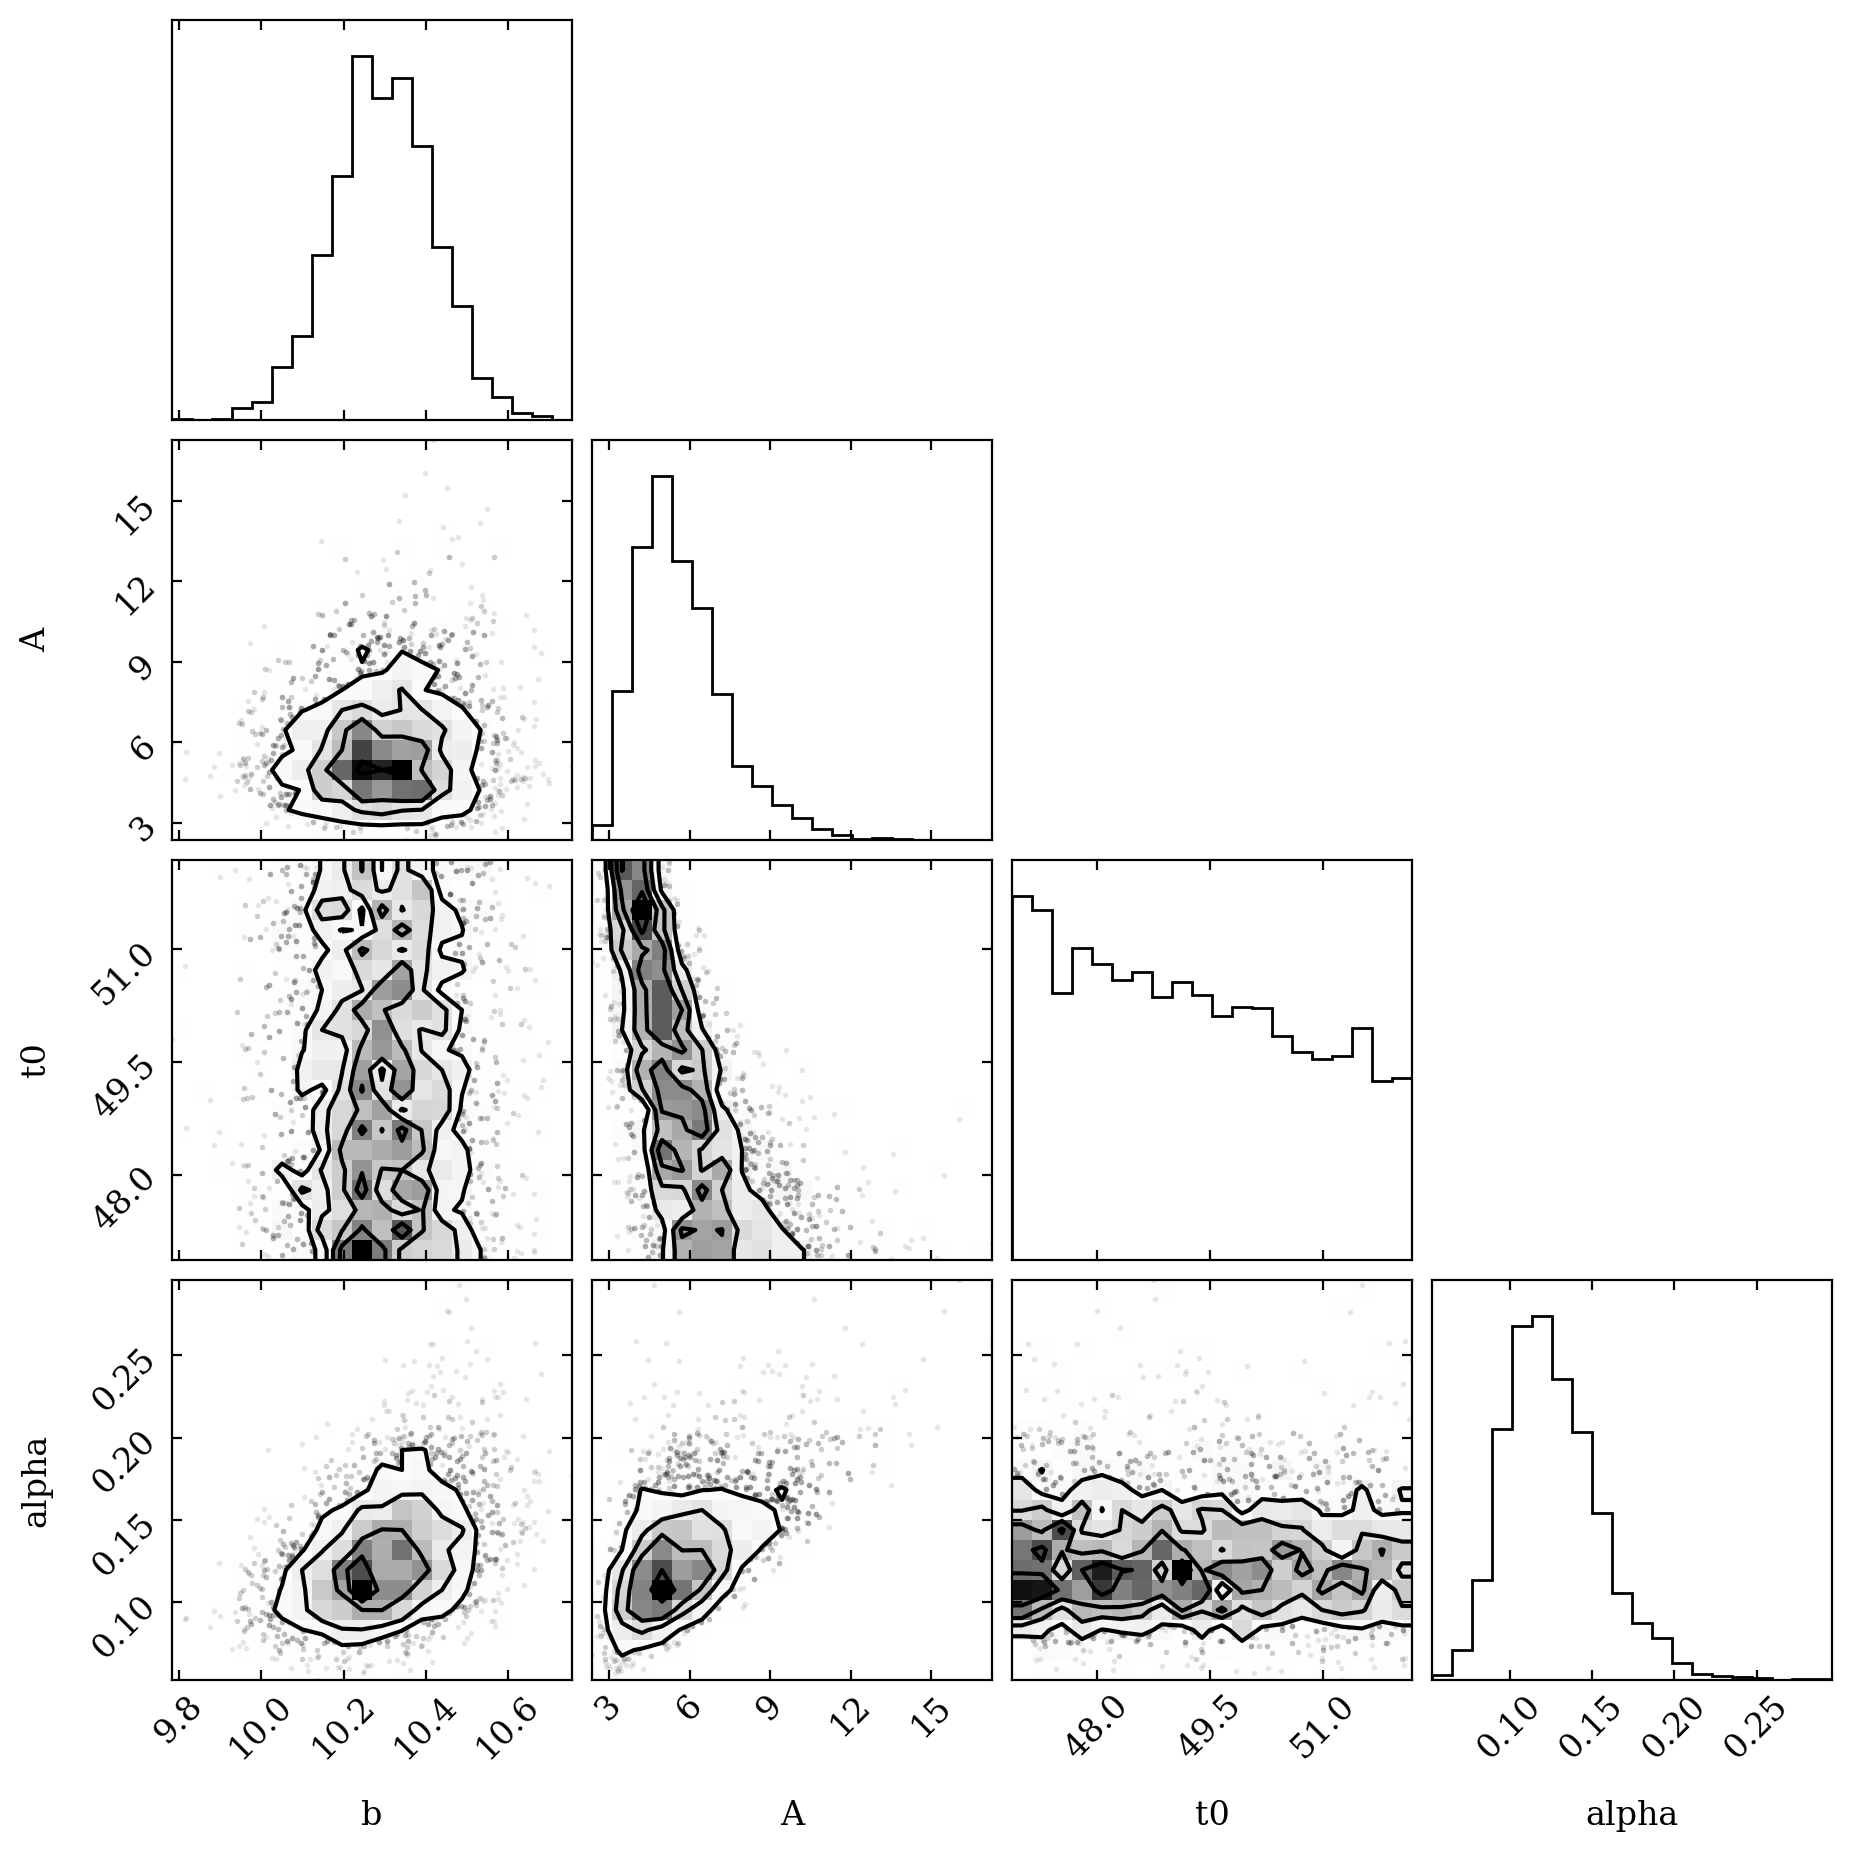

In [18]:
import corner
samples_equal1 = dyfunc.resample_equal(samples1, weights1)
corner.corner(samples_equal1, labels=['b', 'A', 't0', 'alpha']);

### Gaussian

In [19]:
ndim=4
sampler2 = dynesty.NestedSampler(logLikelihood2, Prior_transform2, ndim, logl_args=[t,flux,err])
sampler2.run_nested()
sresults2 = sampler2.results

8111it [03:36, 37.53it/s, +500 | bound: 146 | nc: 1 | ncall: 137697 | eff(%):  6.276 | loglstar:   -inf < -144.343 <    inf | logz: -159.830 +/-  0.175 | dlogz:  0.001 >  0.509]


Results:

Bayesian evidence :  3.859647038153412e-70
b:   10.317   + 0.198   - 0.203
A:   2.744   + 0.643   - 0.57
t0:   55.395   + 1.803   - 1.585
sigmaW:   5.265   + 1.47   - 1.435


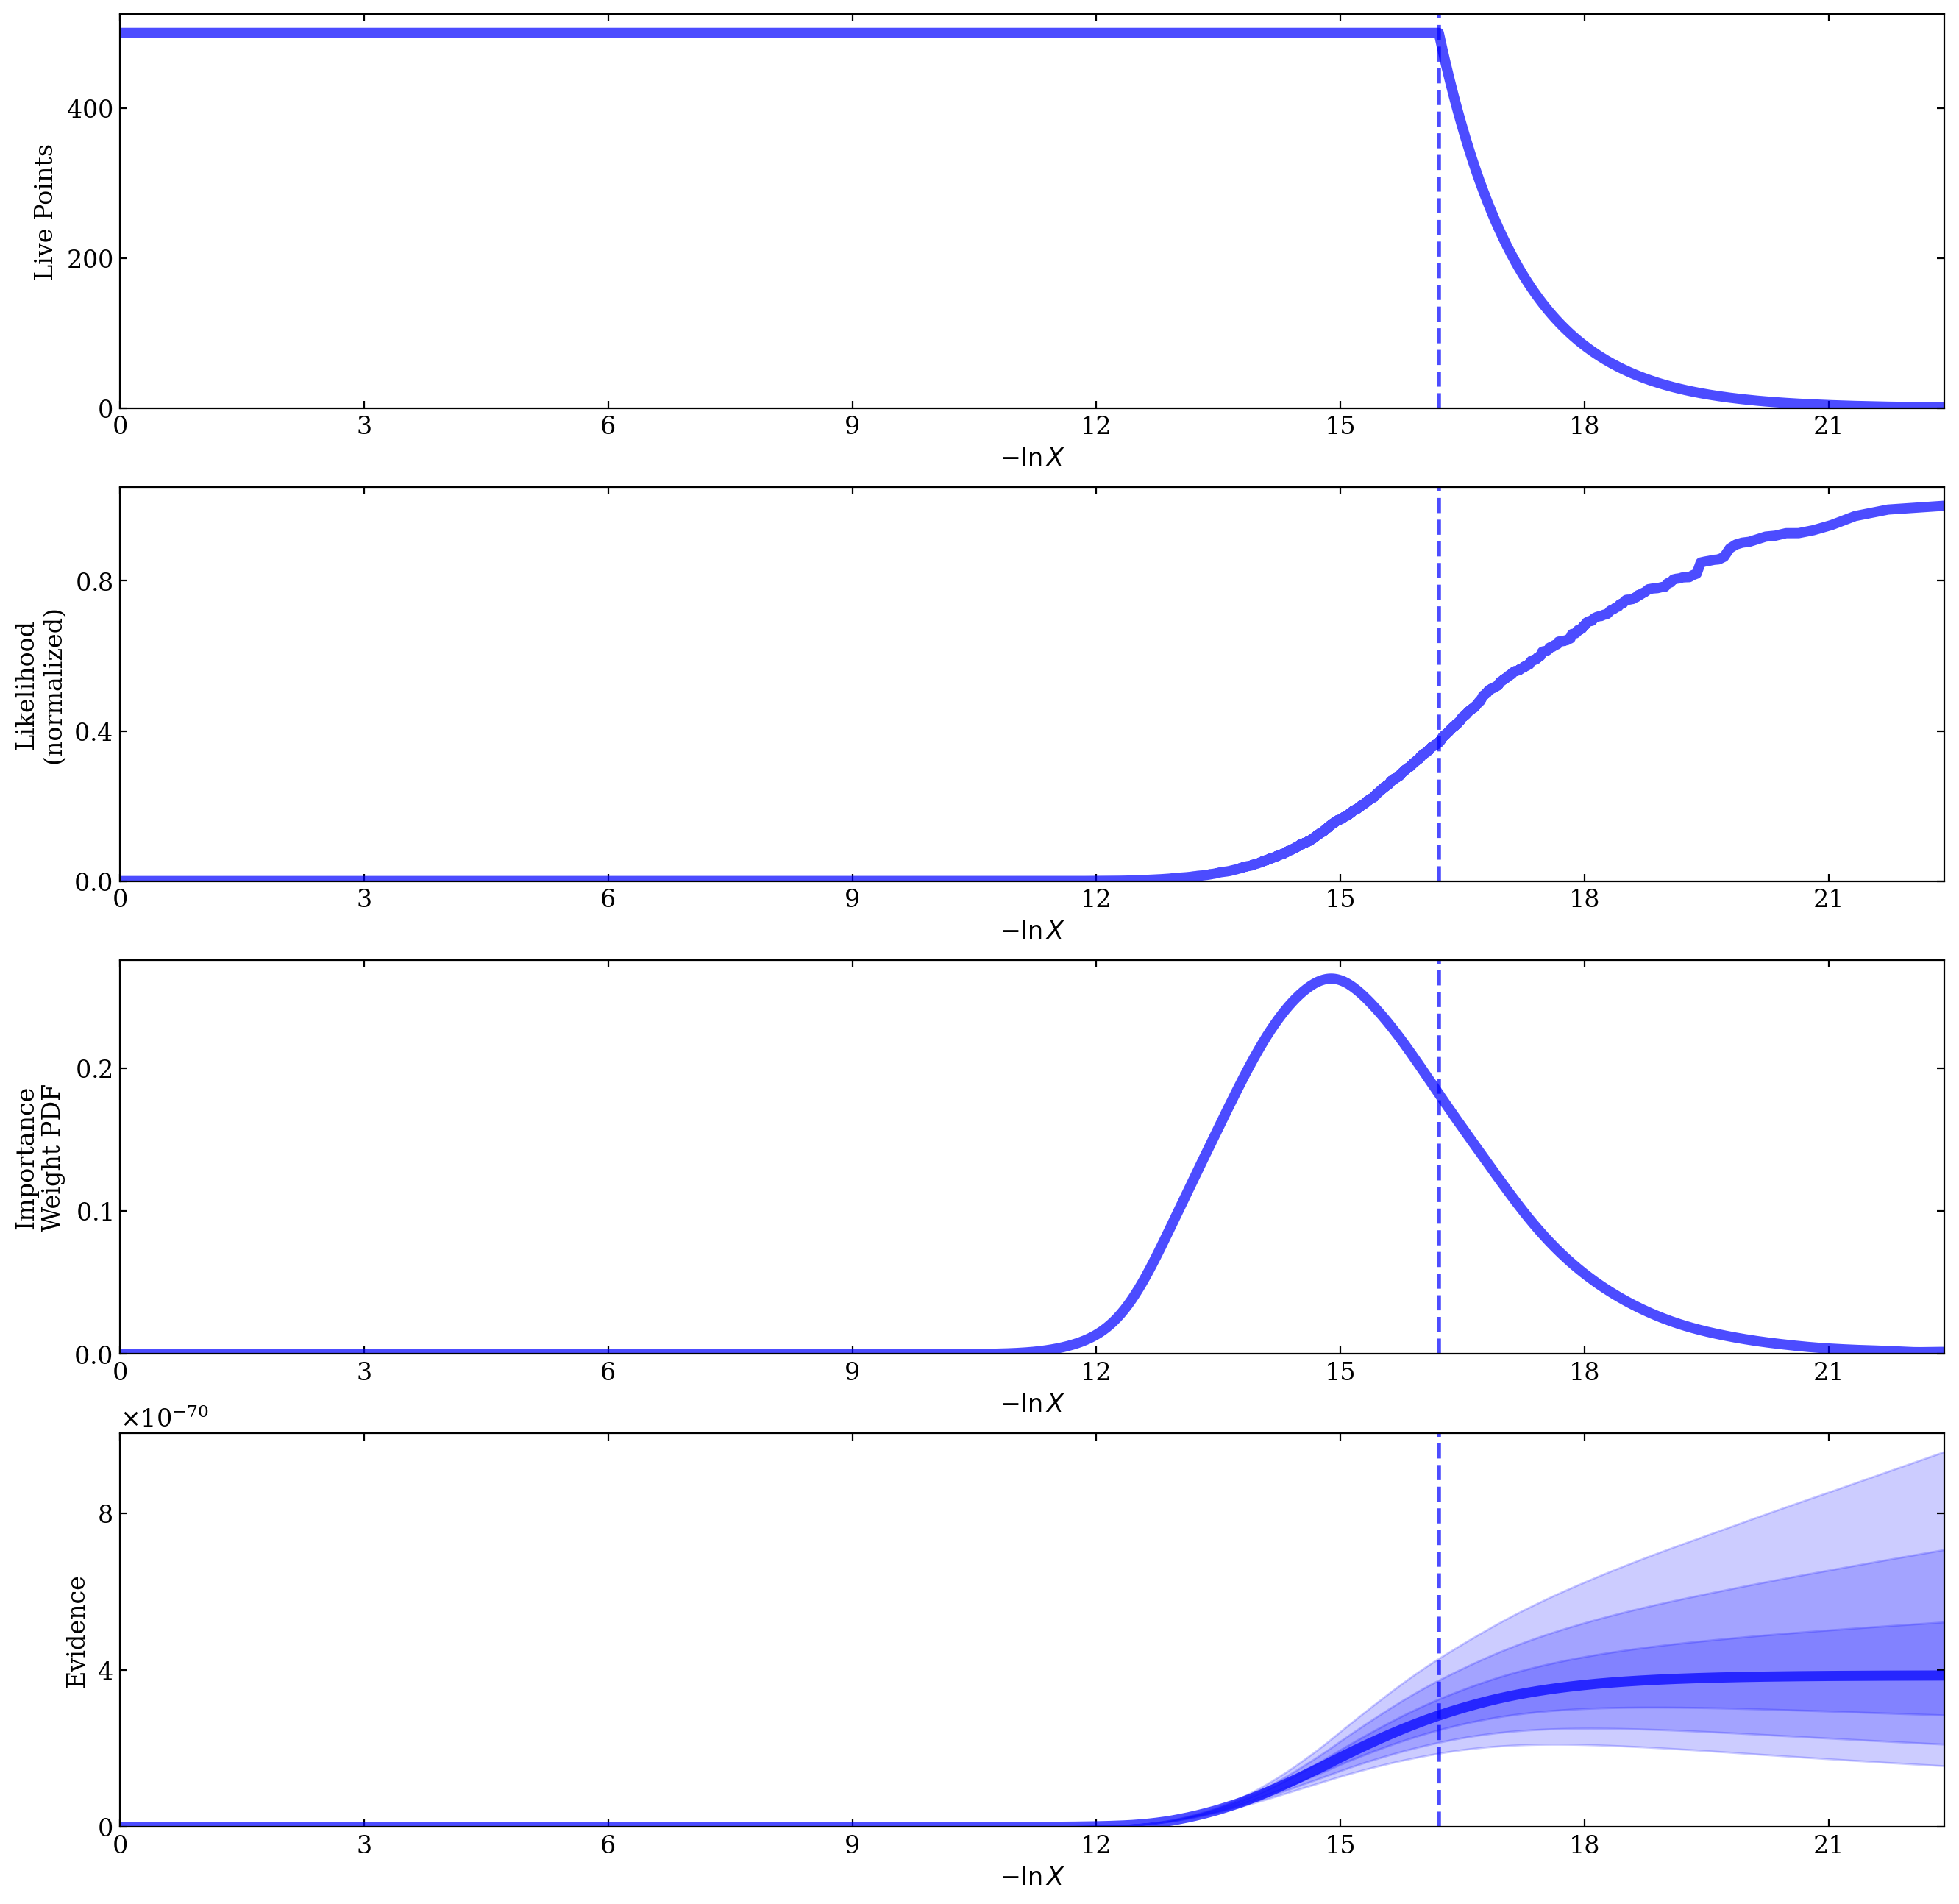

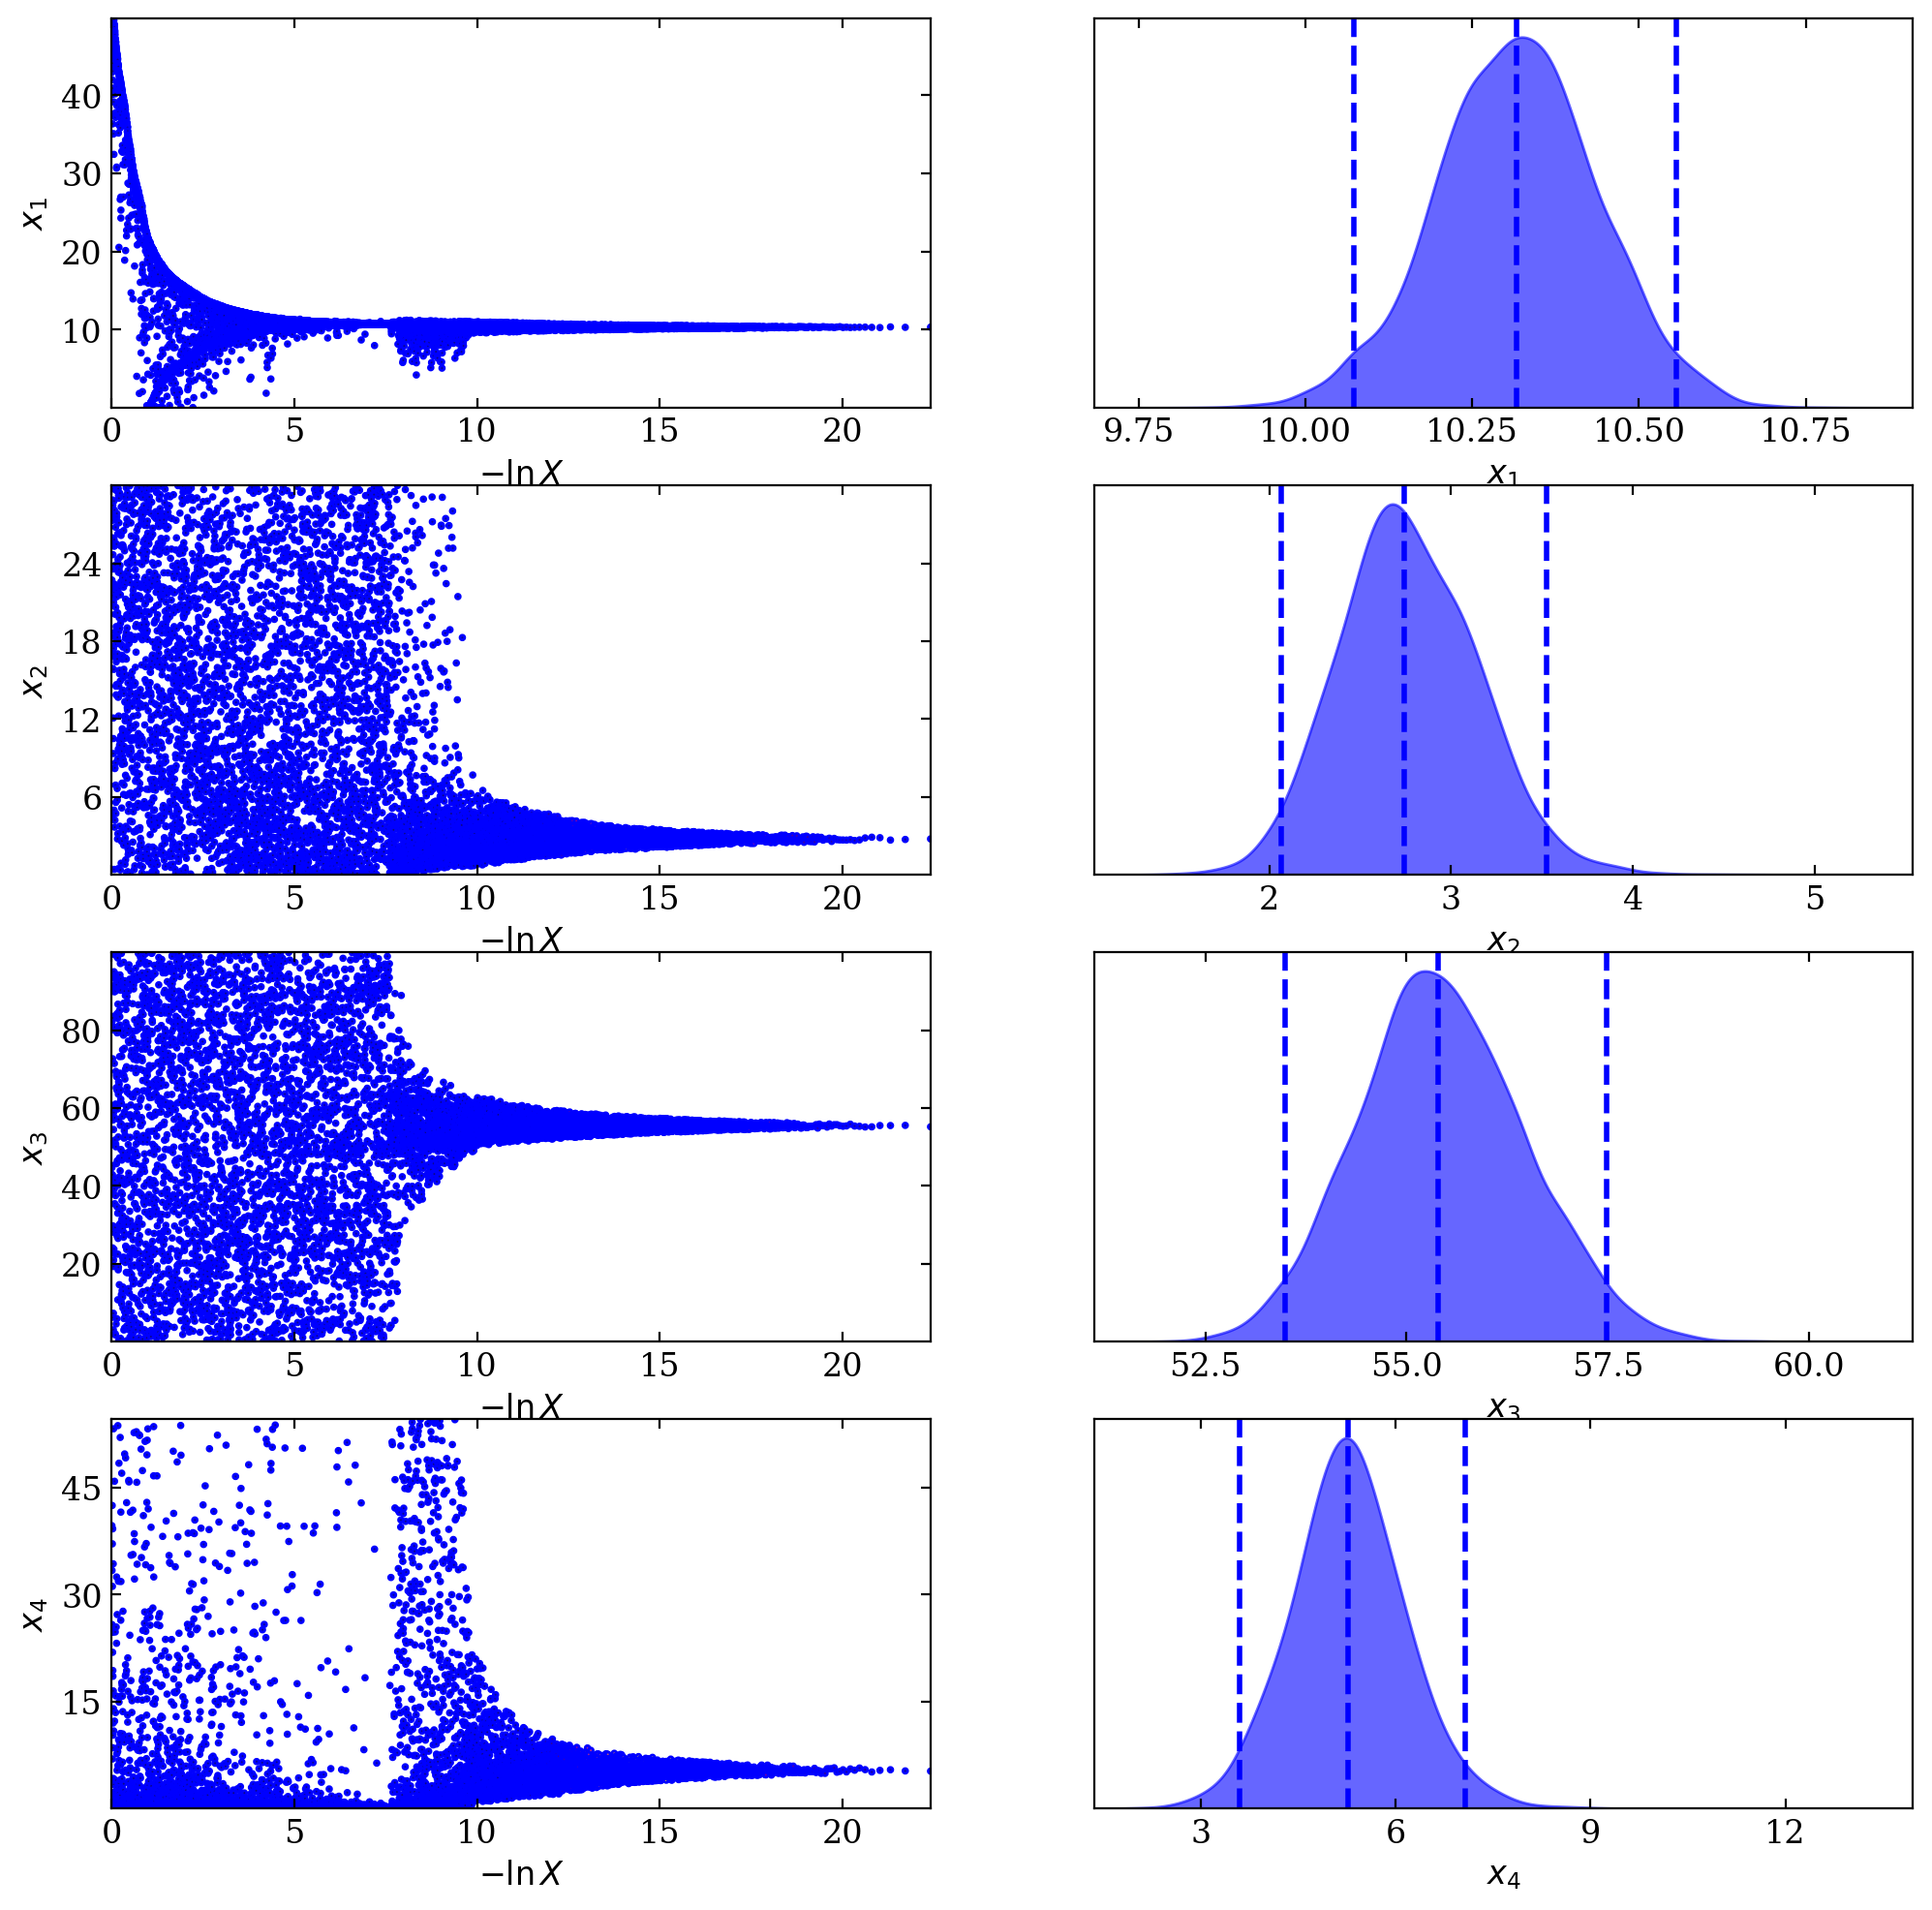

In [20]:
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

rfig, raxes = dyplot.runplot(sresults2)
tfig, taxes = dyplot.traceplot(sresults2)

# Extract sampling results.
print('Results:\n')
samples2 = sresults2.samples
weights2 = np.exp(sresults2.logwt - sresults2.logz[-1])

evidence2 = sresults2.logz[-1]
print("Bayesian evidence : ", np.exp(evidence2))

best_param2 = np.array([dyfunc.quantile(samps, 0.5, weights=weights2)
             for samps in samples2.T])
quantiles2 = np.array([dyfunc.quantile(samps, [0.05, 0.95], weights=weights2)
             for samps in samples2.T])

for i, l in zip(range(ndim),['b','A','t0','sigmaW']):
    X=best_param2[i].item()
    p5, p95 = quantiles2[i]
    print(l+':  ', round(X,3), '  +', round(p95.item()-X,3), '  -', round(X-p5.item(),3))
    
best_model2 = sharp_burst2(tgrid, best_param2)

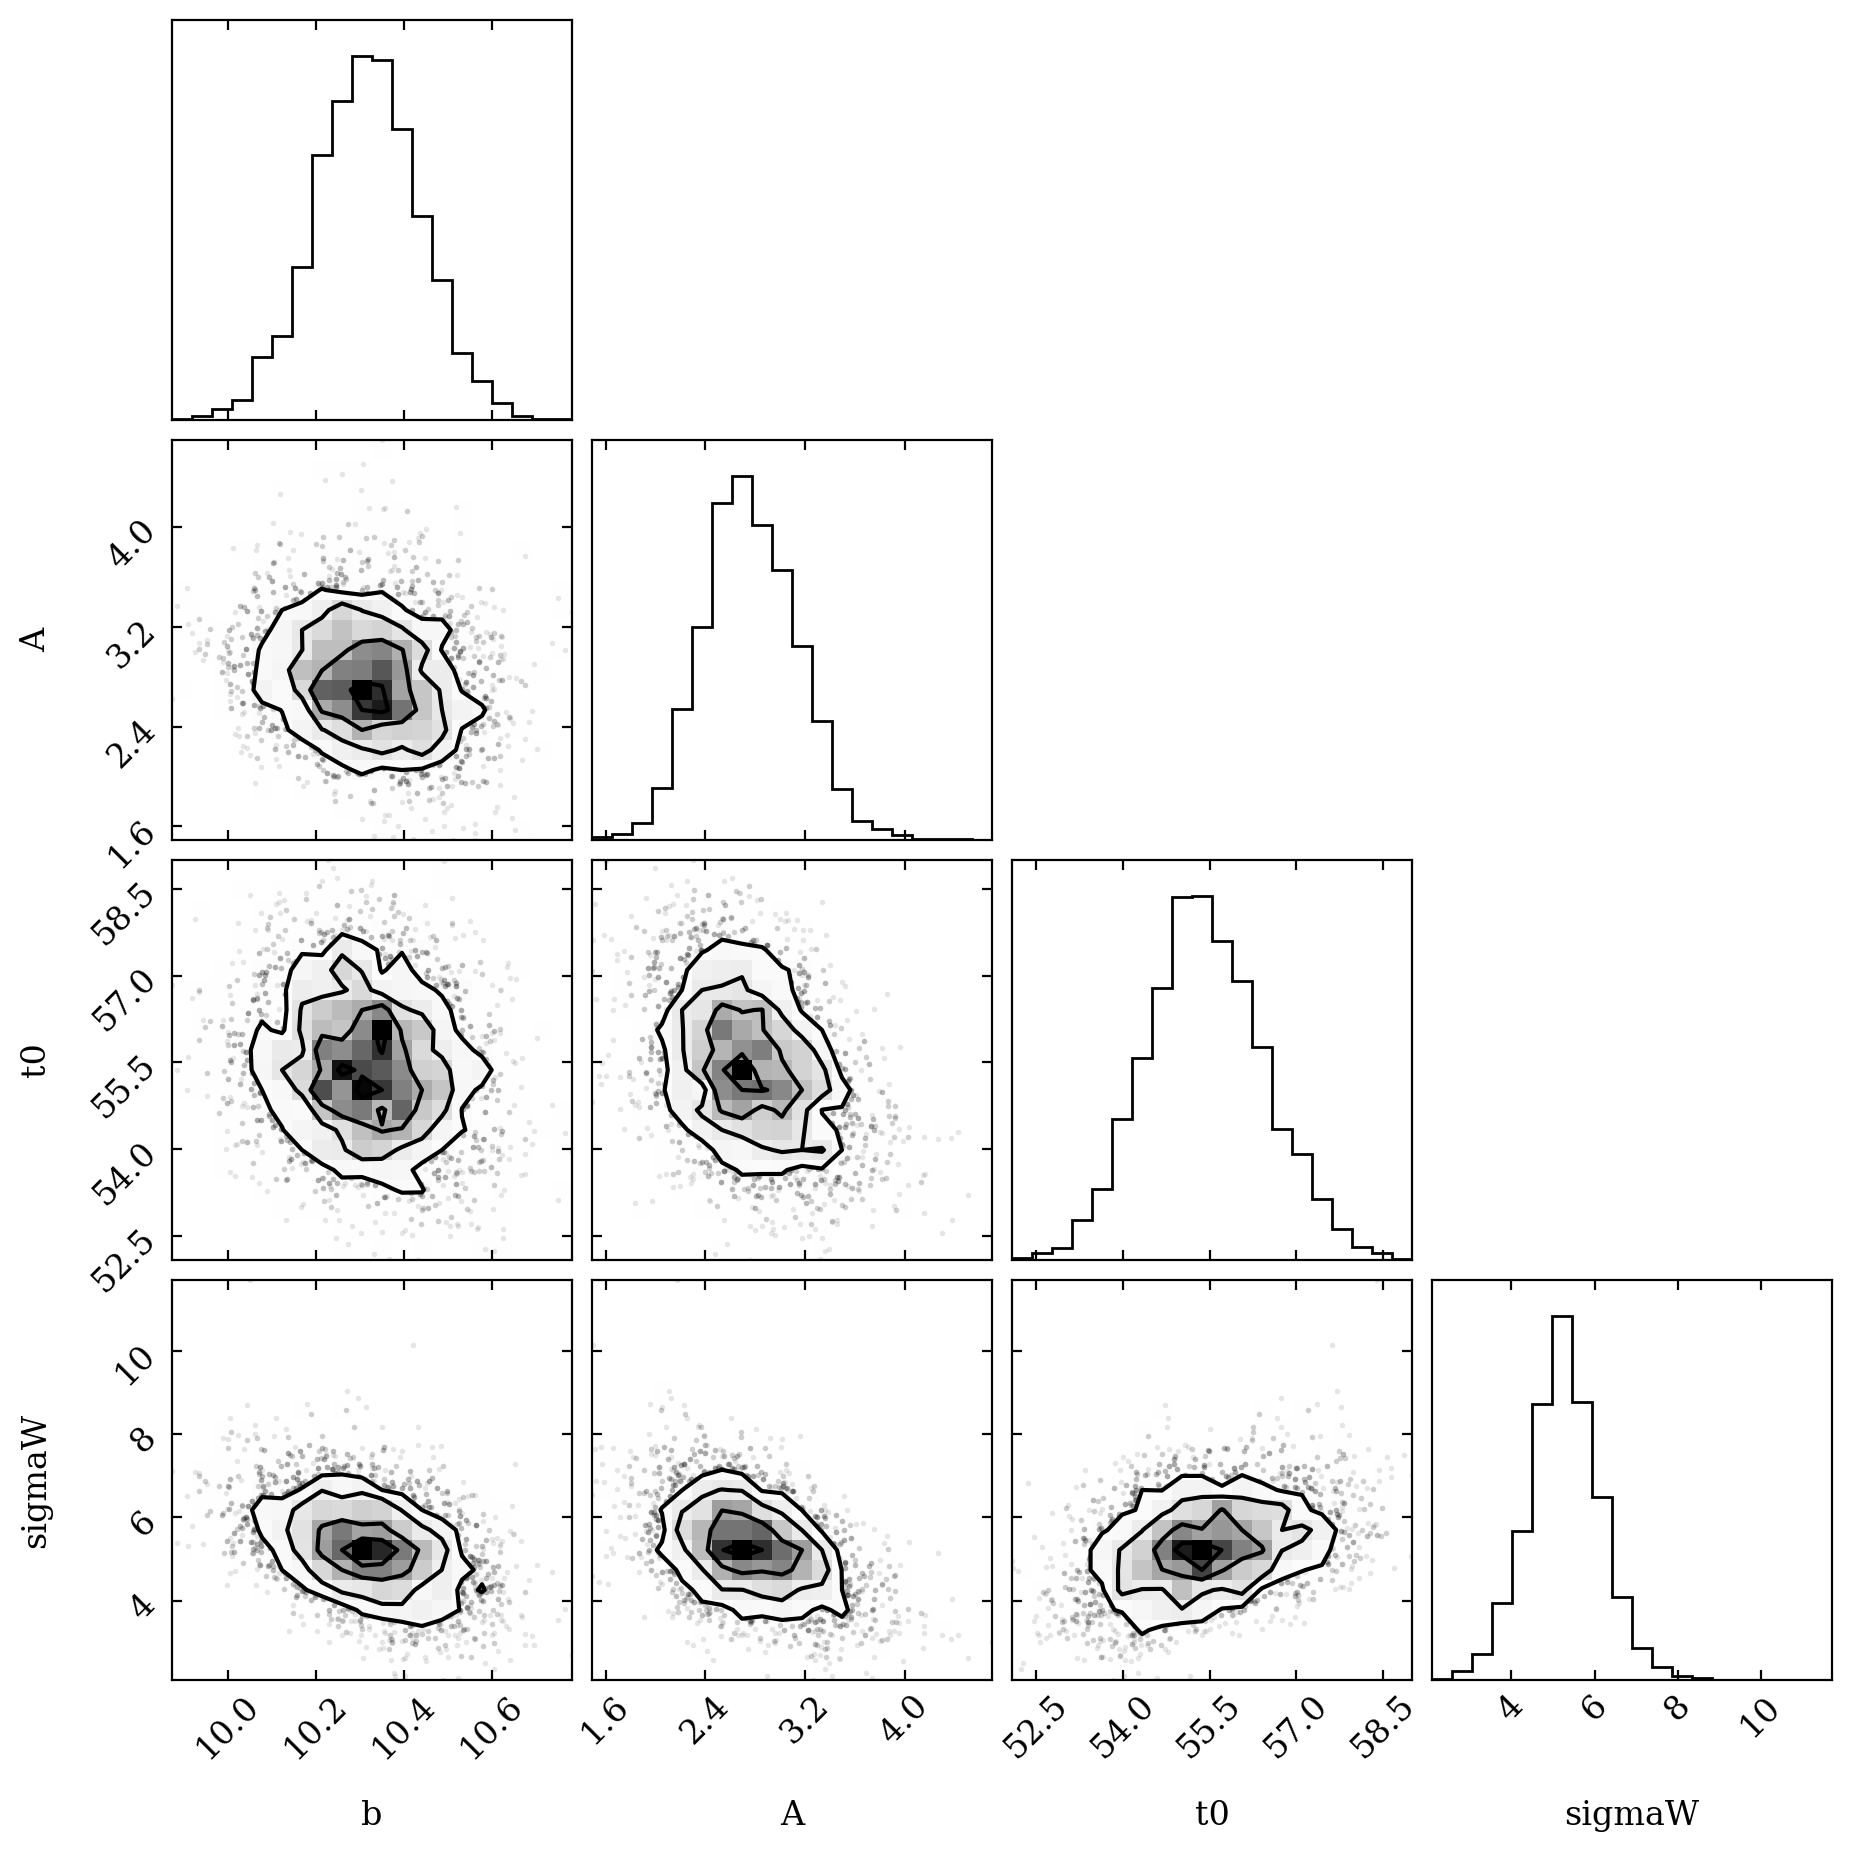

In [21]:
samples_equal2 = dyfunc.resample_equal(samples2, weights2)
corner.corner(samples_equal2, labels=['b', 'A', 't0', 'sigmaW']);

In [22]:
print('Ratio between Evidence1 and Evidence2 = ', np.exp(evidence1)/np.exp(evidence2))

Ratio between Evidence1 and Evidence2 =  105.8015039457052


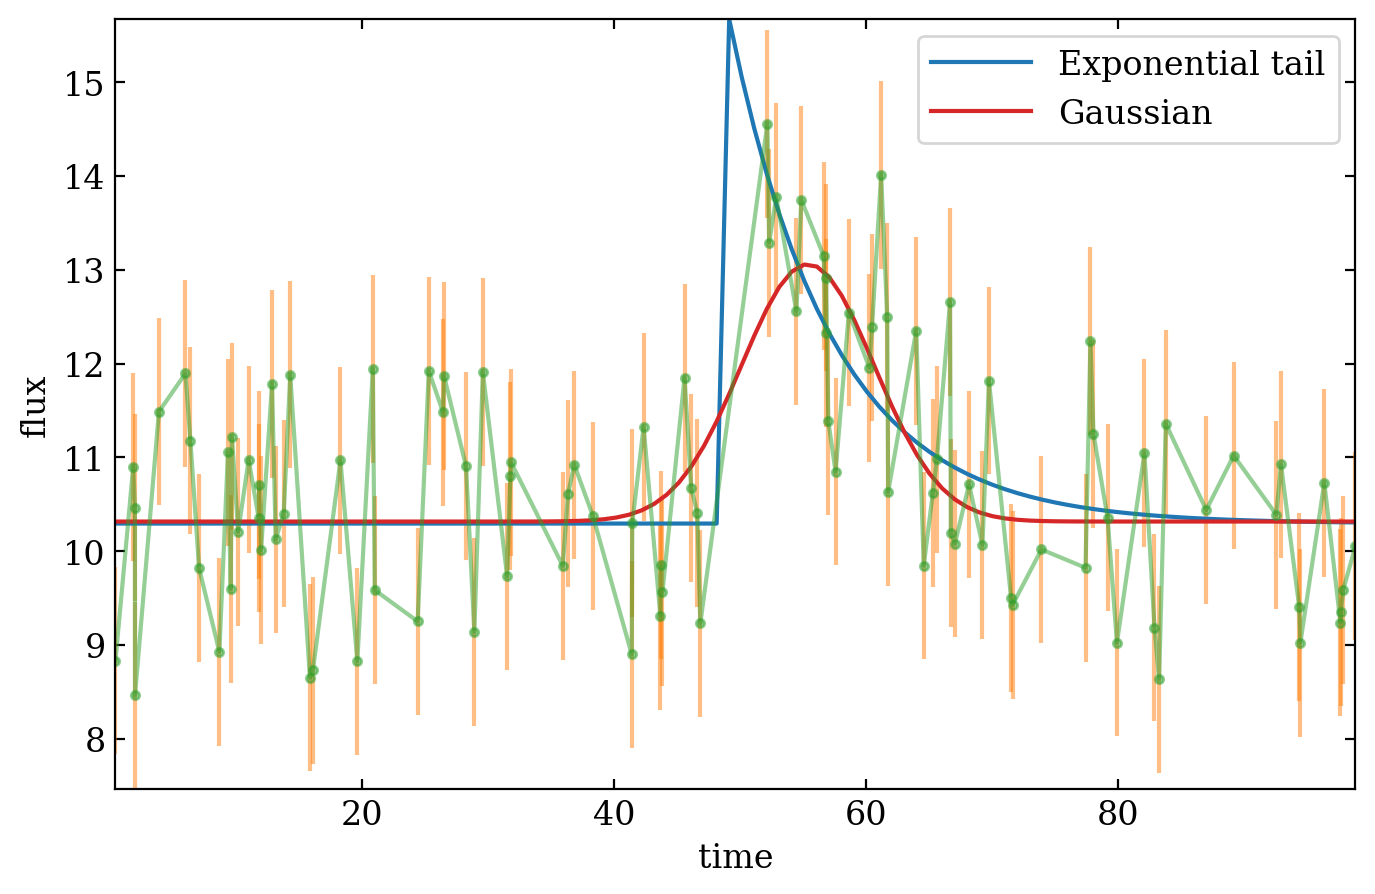

In [23]:
plt.errorbar(t, flux, err, ecolor='C1', capthick=0, marker='.', c='C2',alpha=0.5)
plt.plot(tgrid, best_model1, c='C0', label='Exponential tail')
plt.plot(tgrid, best_model2, c='C3', label='Gaussian')
plt.xlabel('time')
plt.ylabel('flux')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()